In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import src.vargamma_open_source as Vargamma
from scipy.stats import wasserstein_distance
import src.levy_diagnosis as levy
import src.Variance_Gamma as Variance_Gamma
import src.Merton as Merton
import yfinance as yf
from datetime import datetime

count 5029
mean 0.00033649734693832995
std 0.012299493037782156
skew -0.47656751817827947
kurtosis (excess) 12.86568349171414


Estimated tail: 0.38663544281098794
u_max = 20.000 , nombre de points = 16384
Extrait des premières valeurs de u : [0.         0.00122078 0.00244156 0.00366233 0.00488311 0.00610389
 0.00732467 0.00854544 0.00976622 0.010987  ]
Detected 39 jumps with threshold 4.0σ


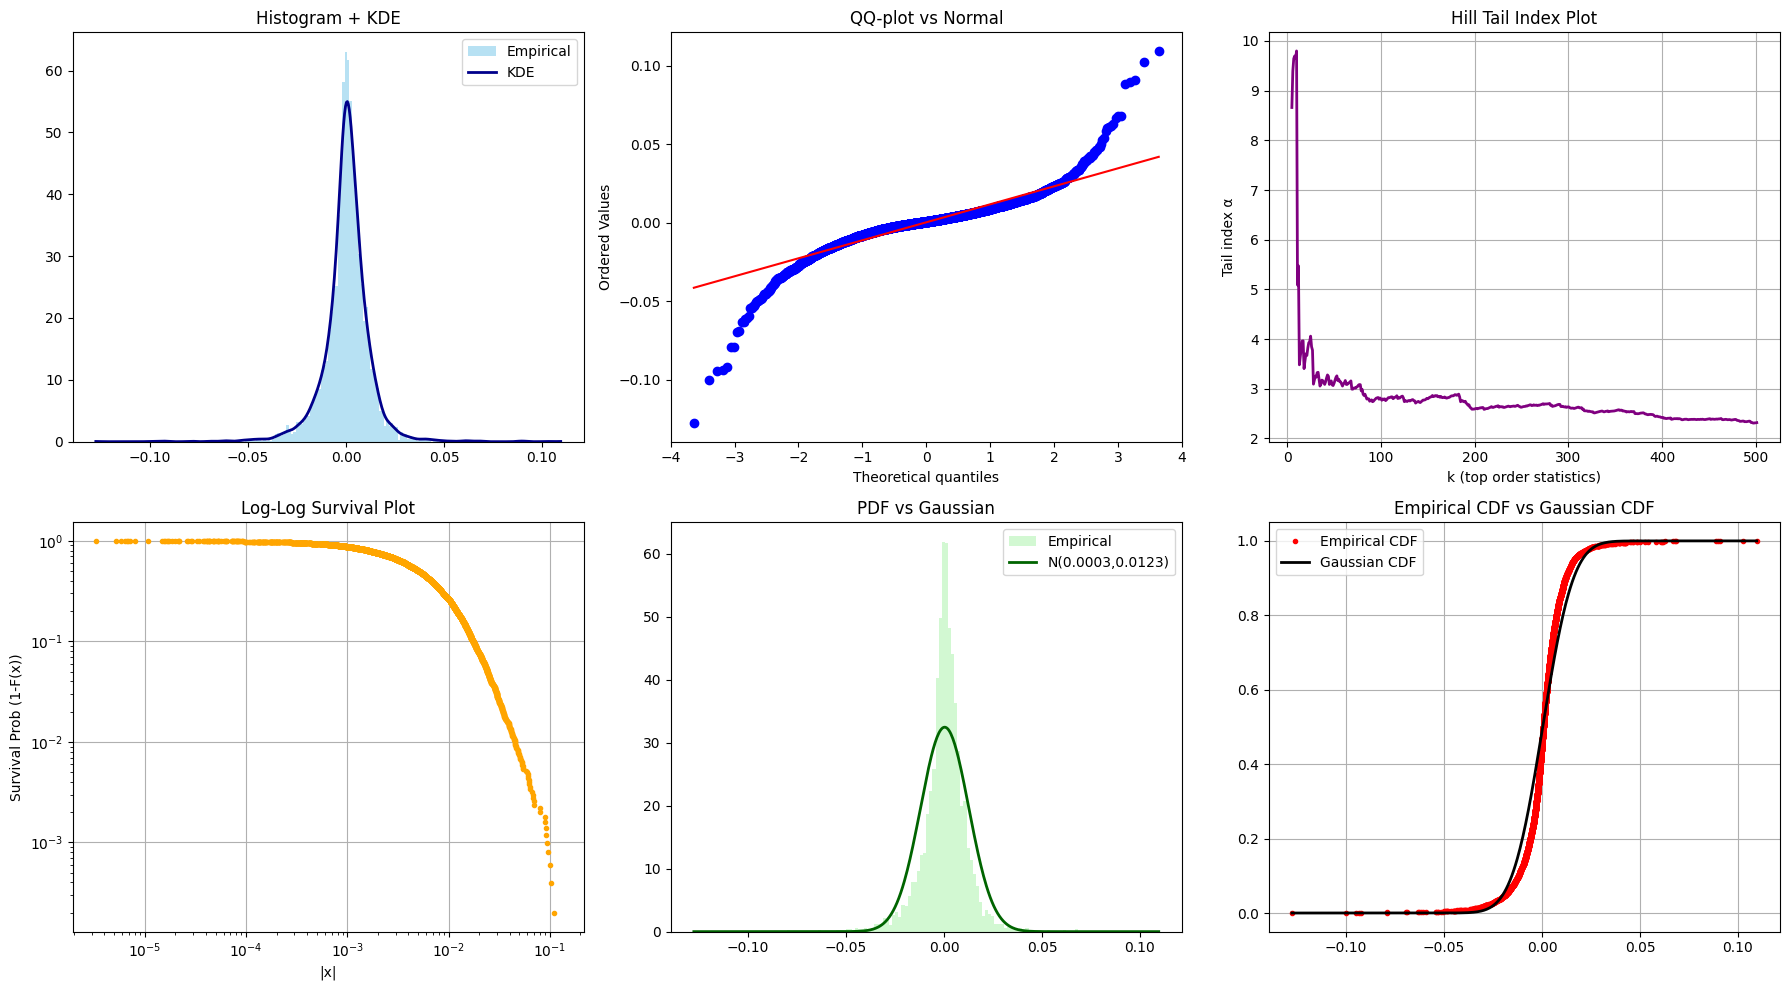

Approx. tail index α = 2.641


In [6]:
# -------------------------
# Chargement des données
# -------------------------
def get_sp500_price():
    sp500 = yf.Ticker("^SPX")
    data = sp500.history(period="20y")
    return data

df = get_sp500_price()

logr = levy.compute_log_returns(df, 'Close')
levy.summary_stats(logr)

# Déterminer la grille de la série
N = 2**14


tail_index = levy.estimate_tail_index(logr)
print("Estimated tail:", tail_index)

u, u_max = levy.make_uniform_u_grid(tail_index, N)
print(f"u_max = {u_max:.3f} , nombre de points = {len(u)}")
print(f"Extrait des premières valeurs de u : {u[:10]}")

# Déterminer et calculer les Jump existant dans la série
jumps = levy.detect_jumps(logr)

# Affichage graphique pertinent
levy.plot_diagnostics(logr, out_prefix="diagnostics")

<div style="
  background:#00008B;color:#fff;padding:12px 16px;border-radius:12px;font-weight:800;font-size:2rem;text-align:center;padding:20px;width:100%;
"> I - Estimation des paramètre avec Variance Gamma</div>

In [ ]:
# -------------------------
# Estimations
# -------------------------

# ECF
params_ecf_vg =  Variance_Gamma.estimate_vg_ecf(logr, u)

# MLE
params_mle_vg = Vargamma.fit(logr)  # tuple (c, sigma, theta, nu)
params_init_mle_vg = Vargamma.fit_moments(logr)

print("=== Résultats d'estimation ===")
print("MLE (Vargamma.fit) :")
print("  c    = {:.6f}".format(params_mle_vg[0]))
print("  sigma= {:.6f}".format(params_mle_vg[1]))
print("  theta= {:.6f}".format(params_mle_vg[2]))
print("  nu   = {:.6f}".format(params_mle_vg[3]))
print()
print("ECF (minimisation) :")
print("  c    = {:.6f}".format(params_ecf_vg[0][0]))
print("  sigma= {:.6f}".format(params_ecf_vg[0][1]))
print("  theta= {:.6f}".format(params_ecf_vg[0][2]))
print("  nu   = {:.6f}".format(params_ecf_vg[0][3]))
print()

=== Résultats d'estimation ===
MLE (Vargamma.fit) :
  c    = 0.000916
  sigma= 0.011434
  theta= -0.000570
  nu   = 1.295532

ECF (minimisation) :
  c    = 0.000807
  sigma= 0.012259
  theta= -0.000471
  nu   = 4.189263



In [18]:
# -------------------------
# Comparaisons / tests
# -------------------------

# KS (statistique) : simuler même taille que logr pour comparabilité
ks_mle = Variance_Gamma.ks_distance_vg(logr, params_mle_vg, n_sim=len(logr), random_state=42)
ks_ecf = Variance_Gamma.ks_distance_vg(logr, tuple(params_ecf_vg[0]), n_sim=len(logr), random_state=43)

# Wasserstein
sim_mle = Variance_Gamma.simulate_vg(len(logr), params_mle_vg, random_state=44)
sim_ecf = Variance_Gamma.simulate_vg(len(logr), tuple(params_ecf_vg[0]), random_state=45)
wd_mle = wasserstein_distance(logr, sim_mle)
wd_ecf = wasserstein_distance(logr, sim_ecf)

# Moments: mean, std, skew, kurtosis
def summary_moments(series):
    return {
        "mean": np.mean(series),
        "std": np.std(series, ddof=1),
        "skew": stats.skew(series),
        "kurtosis": stats.kurtosis(series)  # excess kurtosis stats.kurtosis(logr)
    }

mom_data = summary_moments(logr)
mom_mle  = summary_moments(sim_mle)
mom_ecf  = summary_moments(sim_ecf)

In [19]:
# Affichage récapitulatif
print("=== Comparaisons statistiques ===")
print("KS statistic : MLE = {:.6f}, ECF = {:.6f}".format(ks_mle, ks_ecf))
print("Wasserstein  : MLE = {:.6f}, ECF = {:.6f}".format(wd_mle, wd_ecf))
print()
print("Moments (data vs MLE vs ECF):")
df_mom = pd.DataFrame({
    "data": list(mom_data.values()),
    "MLE" : list(mom_mle.values()),
    "ECF" : list(mom_ecf.values())
}, index=list(mom_data.keys()))
print(df_mom)

=== Comparaisons statistiques ===
KS statistic : MLE = 0.029628, ECF = 0.129648
Wasserstein  : MLE = 0.000644, ECF = 0.001903

Moments (data vs MLE vs ECF):
               data       MLE        ECF
mean       0.000336  0.000454   0.000200
std        0.012299  0.011541   0.012298
skew      -0.476568 -0.076712  -0.728582
kurtosis  12.865683  3.397900  13.485884


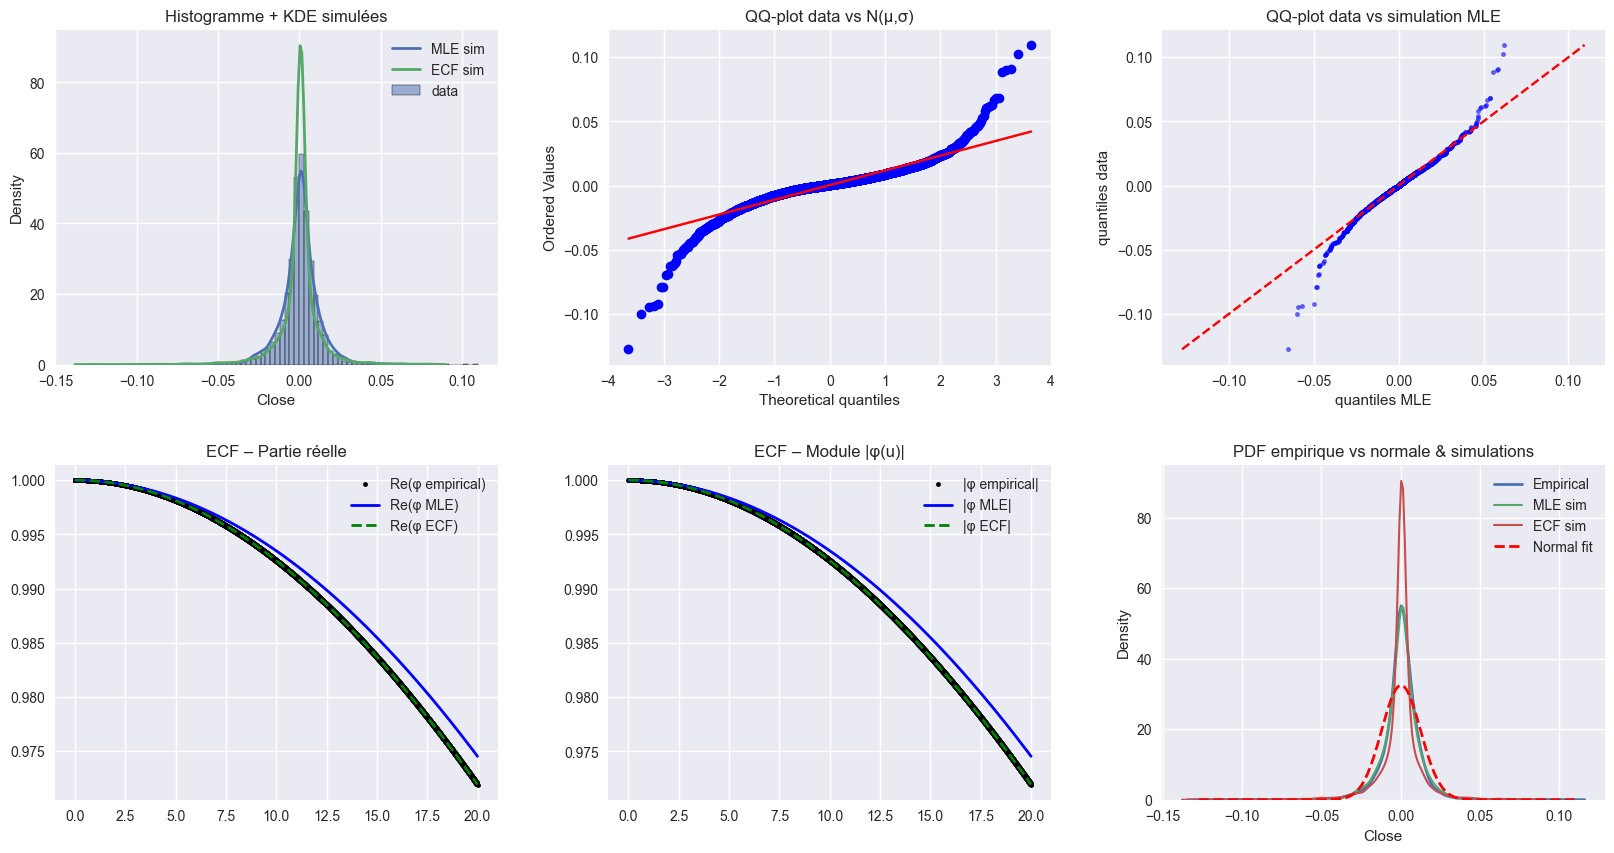

In [24]:
levy.plot_all_vg_diagnostics(logr, sim_mle, sim_ecf, u,
                            params_mle_vg, tuple(params_ecf_vg[0]), "VG")

<div style="
  background:#00008B;color:#fff;padding:12px 16px;border-radius:12px;font-weight:800;font-size:2rem;text-align:center;padding:20px;width:100%;
"> II - Estimation des paramètres avec Merton</div>

In [25]:
# -------------------------
# Estimations
# -------------------------

# ECF
params_ecf_merton =  Merton.estimate_merton_ecf(logr, u)[0]

# MLE
params_mle_merton = Merton.estimate_merton_mle(logr)[0]  # tuple (c, sigma, theta, nu)
params_init_mle = Merton.automatic_init_merton(logr)

# Résultat
print("\n----------------------")
print("PARAMÈTRES INITIAUX MLE (méthode des moments)")
print("  c    = {:.6f}".format(params_init_mle[0]))
print("  sigma = {:.6f}".format(params_init_mle[1]))
print("  lam= {:.6f}".format(params_init_mle[2]))
print("  muJ   = {:.6f}".format(params_init_mle[3]))
print("  sigmaJ   = {:.6f}".format(params_init_mle[4]))
print("----------------------\n")

print("=== Résultats d'estimation ===")
print("MLE Merton :")
print("  c    = {:.6f}".format(params_mle_merton[0]))
print("  sigma = {:.6f}".format(params_mle_merton[1]))
print("  lam= {:.6f}".format(params_mle_merton[2]))
print("  muJ   = {:.6f}".format(params_mle_merton[3]))
print("  sigmaJ   = {:.6f}".format(params_mle_merton[4]))
print()
print("ECF Merton :")
print("  c    = {:.6f}".format(params_ecf_merton[0]))
print("  sigma = {:.6f}".format(params_ecf_merton[1]))
print("  lam= {:.6f}".format(params_ecf_merton[2]))
print("  muJ   = {:.6f}".format(params_ecf_merton[3]))
print("  sigmaJ   = {:.6f}".format(params_ecf_merton[4]))
print()


----------------------
PARAMÈTRES INITIAUX MLE (méthode des moments)
  c    = 0.000740
  sigma = 0.009840
  lam= 0.063034
  muJ   = -0.006884
  sigmaJ   = 0.037715
----------------------

=== Résultats d'estimation ===
MLE Merton :
  c    = 0.001216
  sigma = 0.005923
  lam= 0.367876
  muJ   = -0.002390
  sigmaJ   = 0.016720

ECF Merton :
  c    = 0.000587
  sigma = 0.008389
  lam= 0.067692
  muJ   = -0.003699
  sigmaJ   = 0.034358



In [26]:

# -------------------------
# Comparaisons / tests
# -------------------------

# KS (statistique) : simuler même taille que logr pour comparabilité
ks_mle_merton = Merton.ks_distance_merton(logr, params_mle_merton, n_sim=len(logr), random_state=42)
ks_ecf_merton = Merton.ks_distance_merton(logr, params_ecf_merton, n_sim=len(logr), random_state=43)

# Wasserstein
sim_mle = Merton.simulate_merton(len(logr), params_mle_merton, random_state=44)
sim_ecf = Merton.simulate_merton(len(logr), params_ecf_merton, random_state=45)
wd_mle = wasserstein_distance(logr, sim_mle)
wd_ecf = wasserstein_distance(logr, sim_ecf)

# Moments: mean, std, skew, kurtosis
def summary_moments(series):
    return {
        "mean": np.mean(series),
        "std": np.std(series, ddof=1),
        "skew": stats.skew(series),
        "kurtosis": stats.kurtosis(series)  # excess kurtosis stats.kurtosis(logr)
    }

mom_data = summary_moments(logr)
mom_mle  = summary_moments(sim_mle)
mom_ecf  = summary_moments(sim_ecf)

In [27]:
# Affichage récapitulatif
print("=== Comparaisons statistiques ===")
print("KS statistic : MLE = {:.6f}, ECF = {:.6f}".format(ks_mle_merton, ks_ecf_merton))
print("Wasserstein  : MLE = {:.6f}, ECF = {:.6f}".format(wd_mle, wd_ecf))
print()
print("Moments (data vs MLE vs ECF):")
df_mom = pd.DataFrame({
    "data": list(mom_data.values()),
    "MLE" : list(mom_mle.values()),
    "ECF" : list(mom_ecf.values())
}, index=list(mom_data.keys()))
print(df_mom)


=== Comparaisons statistiques ===
KS statistic : MLE = 0.030026, ECF = 0.061444
Wasserstein  : MLE = 0.000581, ECF = 0.000936

Moments (data vs MLE vs ECF):
               data       MLE        ECF
mean       0.000336  0.000388   0.000342
std        0.012299  0.011579   0.011827
skew      -0.476568 -0.371951  -0.664946
kurtosis  12.865683  3.945544  10.316793


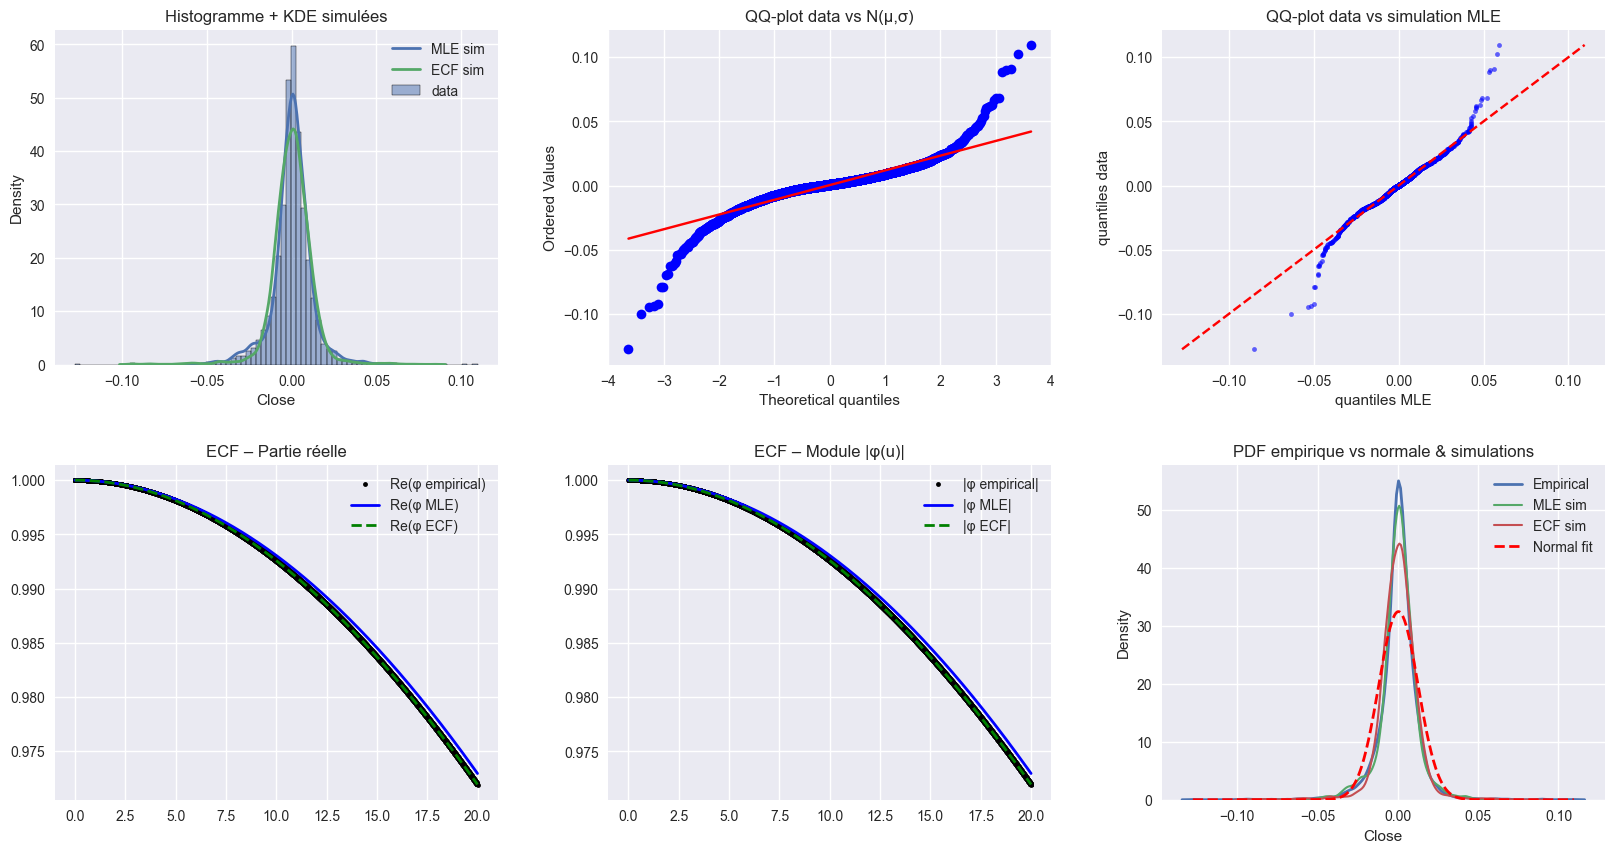

In [28]:
levy.plot_all_vg_diagnostics(logr, sim_mle, sim_ecf, u,
                            params_mle_merton, params_ecf_merton, "Merton")

<div style="
  background:#00008B;color:#fff;padding:12px 16px;border-radius:12px;font-weight:800;font-size:2rem;text-align:center;padding:20px;width:100%;
"> III - Calcul du prix d’un call Europ´een</div>

### 1. Selectionné les option à 6 mois

In [33]:
vix = yf.Ticker("^SPX")
expirations = vix.options
print("Expirations disponibles : ", expirations)
expiry = '2026-03-20'
opt_chain = vix.option_chain(expiry)
calls = opt_chain.calls
puts = opt_chain.puts
calls['expiry'] = expiry
calls = calls[['contractSymbol', 'strike', 'lastPrice', 'bid', 'ask', 'expiry']]
print(calls.head())

Expirations disponibles :  ('2025-12-08', '2025-12-09', '2025-12-10', '2025-12-11', '2025-12-12', '2025-12-15', '2025-12-16', '2025-12-17', '2025-12-18', '2025-12-19', '2025-12-22', '2025-12-23', '2025-12-24', '2025-12-26', '2025-12-29', '2025-12-30', '2025-12-31', '2026-01-02', '2026-01-05', '2026-01-06', '2026-01-07', '2026-01-08', '2026-01-09', '2026-01-12', '2026-01-13', '2026-01-15', '2026-01-16', '2026-01-22', '2026-01-23', '2026-01-30', '2026-02-20', '2026-02-27', '2026-03-20', '2026-03-31', '2026-04-17', '2026-04-30', '2026-05-15', '2026-05-29', '2026-06-18', '2026-06-30', '2026-07-17', '2026-08-21', '2026-09-18', '2026-09-30', '2026-10-16', '2026-11-20', '2026-12-18', '2027-01-15', '2027-06-17', '2027-12-17', '2028-12-15', '2029-12-21', '2030-12-20')
       contractSymbol  strike  lastPrice     bid     ask      expiry
0  SPX260320C00200000   200.0    6631.70  6642.9  6666.9  2026-03-20
1  SPX260320C00400000   400.0    6190.24  6445.4  6469.4  2026-03-20
2  SPX260320C00600000  

### 2. Prendre le taux à 6 mois et autre paramètres

In [ ]:
r = pd.read_csv("data/daily-treasury-rates_T_Bill.csv")
r['6M_risk_free'] = r['26 WEEKS COUPON EQUIVALENT'] / 100  # convertir en décimal
last_risk_free = r.iloc[-1]['6M_risk_free']
print("Taux neutre au risque 6 mois :", last_risk_free)

Taux neutre au risque 6 mois : 0.0383


In [ ]:
expiry = '2026-03-20'                
ticker = "^SPX"                      
r = 0.0383                       
q = 0.0                             
# VG MLE params
c = 0.000916

sigma = 0.011433
theta = -0.000564
nu = 1.29679
eta=0.025
u = np.arange(N) * eta
# damping
alpha = 1.2
# Drift correction pour mesure risque-neutre
w = np.log( (1 - theta*nu + 0.5*sigma**2 * nu)**(-1/nu) )

In [ ]:
# 2) récupérer S0 et construire T
tday = datetime(2025,12,2)          
expiry_dt = datetime.strptime(expiry, "%Y-%m-%d")
T_days = (expiry_dt - tday).days
T = T_days / 365.25
S0 = yf.Ticker(ticker).history(period="1d")['Close'].iat[-1]
print("S0 =", S0, " T (années)=", T, "jours=", T_days)

S0 = 6870.39990234375  T (années)= 0.29568788501026694 jours= 108


### 3. Résultat et représentation graphique

In [37]:
df_calls = levy.price_fft(
    S0=S0,
    r=r,
    T=T,
    phi=lambda u: levy.phi_vg_car(u, theta, nu, sigma, T, S0, r, q, w),
    alpha=1.2,
    N=N,
    eta=0.025
)

# Limiter à la zone réaliste autour du spot
df_calls = df_calls[df_calls["K"].between(0.5*S0, 1.5*S0)]
print(df_calls.head(20))

                K            C
4073  3445.024306  3464.458414
4074  3498.277722  3411.804769
4075  3552.354332  3358.337211
4076  3607.266862  3304.043160
4077  3663.028233  3248.909838
4078  3719.651568  3192.924275
4079  3777.150190  3136.073296
4080  3835.537629  3078.343525
4081  3894.827625  3019.721378
4082  3955.034130  2960.193062
4083  4016.171312  2899.744569
4084  4078.253555  2838.361678
4085  4141.295471  2776.029946
4086  4205.311892  2712.734706
4087  4270.317883  2648.461068
4088  4336.328742  2583.193908
4089  4403.360001  2516.917872
4090  4471.427433  2449.617366
4091  4540.547056  2381.276558
4092  4610.735135  2311.879371


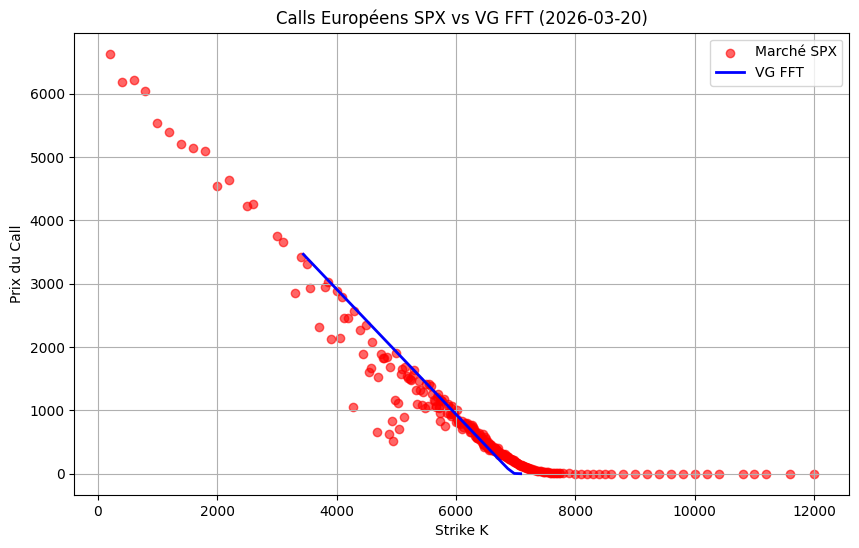

In [ ]:
plt.figure(figsize=(10,6))

# Calls marché
plt.scatter(calls['strike'], calls['lastPrice'],
            color='red', label='Marché SPX', alpha=0.6)

# Calls calculés VG FFT
plt.plot(df_calls['K'], df_calls['C'], color='blue', label='VG FFT', linewidth=2)

plt.xlabel("Strike K")
plt.ylabel("Prix du Call")
plt.title(f"Calls Européens SPX vs VG FFT ({expiry})")
plt.legend()
plt.grid(True)
plt.show()


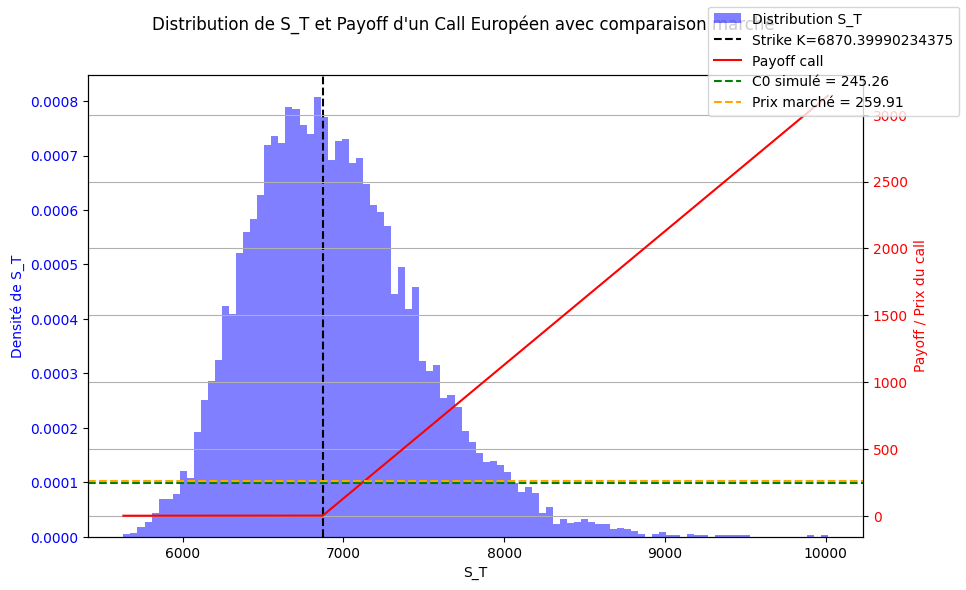

In [ ]:
# Choisir un strike
K_focus = S0  # ATM

# Simuler la distribution de S_T via le modèle VG
ST_samples = levy.simulate_vg_price(10000, S0, T, c, theta, nu, sigma, r, q=0.0, random_state=None)

# Calculer le payoff et le prix actuel
payoff = np.maximum(ST_samples - K_focus, 0)
C0 = np.exp(-r*T) * np.mean(payoff)

market_price = calls.iloc[(calls['strike'] - K_focus).abs().argmin()]['lastPrice']

payoff = np.maximum(ST_samples - K_focus, 0)
C0 = np.exp(-r*T) * np.mean(payoff)

# Graphique
fig, ax1 = plt.subplots(figsize=(10,6))

# Histogramme de S_T
counts, bins, patches = ax1.hist(ST_samples, bins=100, density=True, alpha=0.5, color='blue', label='Distribution S_T')
ax1.set_xlabel("S_T")
ax1.set_ylabel("Densité de S_T", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Axe secondaire pour le payoff
ax2 = ax1.twinx()
ST_sorted = np.sort(ST_samples)
payoff_sorted = np.maximum(ST_sorted - K_focus, 0)
ax2.plot(ST_sorted, payoff_sorted, color='red', label='Payoff call')
ax2.axhline(C0, color='green', linestyle='--', label=f"C0 simulé = {C0:.2f}")
ax2.axhline(market_price, color='orange', linestyle='--', label=f"Prix marché = {market_price:.2f}")
ax2.set_ylabel("Payoff / Prix du call", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Ligne verticale du strike
ax1.axvline(K_focus, color='black', linestyle='--', label=f"Strike K={K_focus}")

# Légende et titre
fig.suptitle("Distribution de S_T et Payoff d'un Call Européen avec comparaison marché")
fig.legend(loc='upper right')
plt.grid(True)
plt.show()